In [15]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [4]:
transactions = pd.read_csv('Comfy_Data/Transactions.csv', sep = ';')

In [5]:
# Convert 'Sale_Return', 'Client_id', 'Credit', and 'SKU_id', 'Revenue', 'Quantity'  to numeric types
transactions['Revenue'] = pd.to_numeric(transactions['Revenue'], errors='coerce')
transactions['Quantity'] = pd.to_numeric(transactions['Quantity'], errors='coerce')
transactions['Sale_Return'] = pd.to_numeric(transactions['Sale_Return'], errors='coerce')
transactions['Client_id'] = pd.to_numeric(transactions['Client_id'], errors='coerce')
transactions['Credit'] = pd.to_numeric(transactions['Credit'], errors='coerce')
transactions['SKU_id'] = pd.to_numeric(transactions['SKU_id'], errors='coerce')

#Convert to date time 
transactions['Date'] = pd.to_datetime(transactions['Date'], errors='coerce')

In [8]:
print(transactions[['Business', 'Brand', 'Revenue']].info())
print(transactions[['Revenue']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679916 entries, 0 to 2679915
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Business  object 
 1   Brand     object 
 2   Revenue   float64
dtypes: float64(1), object(2)
memory usage: 61.3+ MB
None
            Revenue
count  2.655394e+06
mean   4.439603e+03
std    4.225312e+05
min   -2.880000e+05
25%    1.890000e+02
50%    6.990000e+02
75%    2.899000e+03
max    5.399100e+08


In [9]:
# Clean and filter data
treemap_data = transactions[
    (transactions['Revenue'] > 0) &
    (transactions['Business'].notna()) &
    (transactions['Brand'].notna())
]

# Group and aggregate revenue
grouped = treemap_data.groupby(['Business', 'Brand'])['Revenue'].sum().reset_index()

# Double-check aggregation worked
print(grouped.head())

      Business       Brand    Revenue
0  Accessories       1MORE    53473.0
1  Accessories  1stCharger    63869.0
2  Accessories   1stPlayer    31345.0
3  Accessories          2E  3299957.0
4  Accessories     4smarts     2923.0


<h2>Treemap</h2>

📦 Revenue contribution by Business and Brand <br>
🌍 Sales by Region → Business Category<br>

In [11]:
fig = px.treemap(
    grouped,
    path=['Business', 'Brand'],
    values='Revenue',
    color='Revenue',
    color_continuous_scale='viridis',
    title='Revenue Contribution by Business and Brand'
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()
fig.write_html("revenue_treemap.html")

In [12]:
# Step 1: Filter valid data
treemap_region = transactions[
    (transactions['Revenue'] > 0) &
    (transactions['Region'].notna()) &
    (transactions['Business'].notna())
]

# Step 2: Group by Region and Business
grouped_region = treemap_region.groupby(['Region', 'Business'])['Revenue'].sum().reset_index()

# Step 3: Create Treemap
fig = px.treemap(
    grouped_region,
    path=['Region', 'Business'],
    values='Revenue',
    color='Revenue',
    color_continuous_scale='blues',
    title='Revenue by Region and Business'
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Step 4: Show plot
fig.show()

# Step 5: Save as HTML
fig.write_html("region_business_treemap.html")

<h2>Bubble Chart – Top Brands by Revenue vs Return Rate</h2>

In [14]:
# Step 1: Compute returns and revenue per brand
returns = transactions[transactions['Sale_Return'] == 0]
sales = transactions[transactions['Sale_Return'] == 1]

# Total revenue and transactions
brand_sales = sales.groupby('Brand').agg({
    'Revenue': 'sum',
    'Receipt_id': 'count'
}).rename(columns={'Receipt_id': 'Transactions'}).reset_index()

# Return count
brand_returns = returns.groupby('Brand').size().reset_index(name='Returns')

# Merge
brand_perf = brand_sales.merge(brand_returns, on='Brand', how='left')
brand_perf['Returns'] = brand_perf['Returns'].fillna(0)

# Return rate
brand_perf['Return_Rate'] = brand_perf['Returns'] / brand_perf['Transactions']

# Plot
fig = px.scatter(
    brand_perf,
    x='Revenue',
    y='Return_Rate',
    size='Transactions',
    color='Brand',
    hover_name='Brand',
    size_max=60,
    title='Brand Performance: Revenue vs Return Rate'
)

fig.update_layout(xaxis_title='Total Revenue', yaxis_title='Return Rate')
fig.show()
fig.write_html("brand_performance_scatter.html")

<h2>3D Scatter Plot with Bubble Size</h2>
What It Shows:
	•	Axes: Key customer metrics such as Frequency, Recency, and Monetary (or Estimated CLV).
	•	Bubble Size: Represents an additional metric (for example, Estimated CLV or Total Revenue).
	•	Color: Differentiates customer segments (e.g., Best, Loyal, At Risk).

This plot gives a quick multidimensional view of customer behavior, highlights clusters or outliers, and visually distinguishes high-value segments.

The code can be found in file comfy_dataExploration.ipynb since it invloves RFM analysis

<h2>Stacked Area Chart</h2>
Visualize Monthly Revenue broken down by Business and Channel
When specific categories (e.g., Accessories or Appliances) peaked or slumped
Whether online or retail is gaining traction over time
How overall revenue trends are shaped by contributors

<Figure size 1400x700 with 0 Axes>

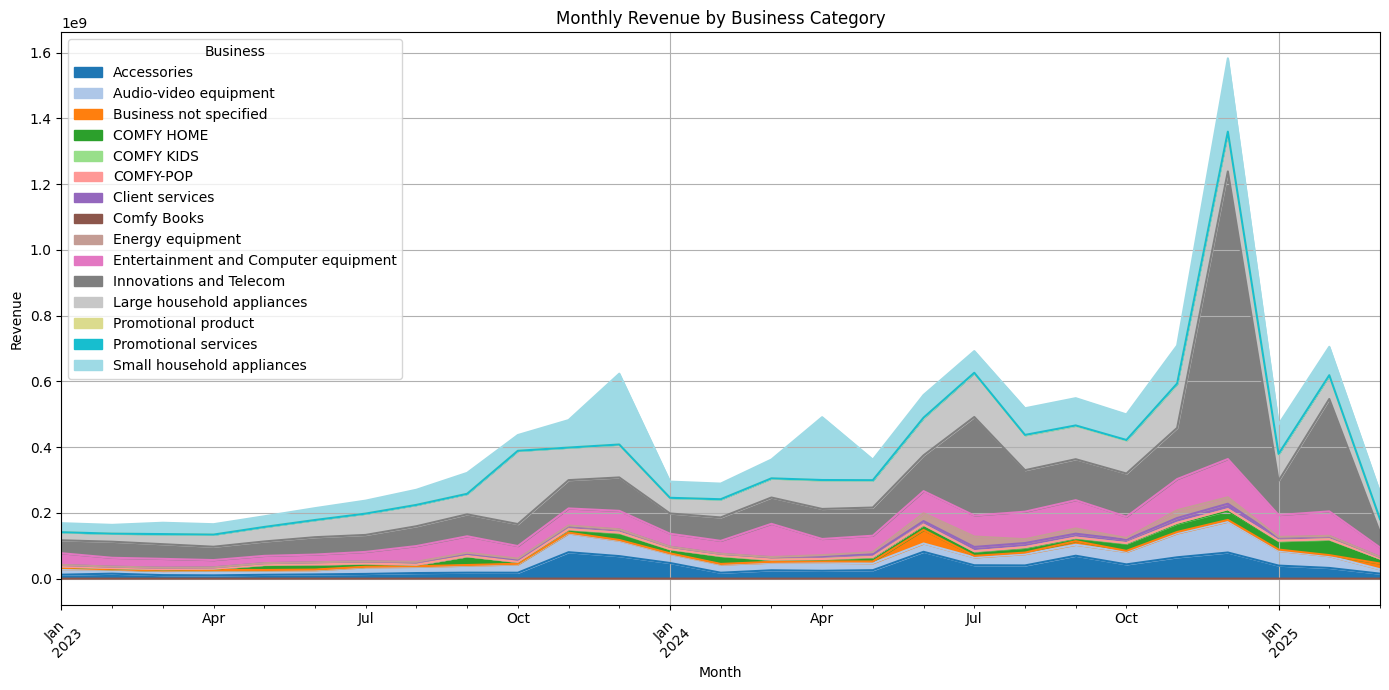

In [16]:
# Ensure Month is available in datetime format
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions['Month'] = transactions['Date'].dt.to_period('M').dt.to_timestamp()

# Group by Month and Business
monthly_business = transactions.groupby(['Month', 'Business'])['Revenue'].sum().reset_index()

# Pivot for area plot
pivoted = monthly_business.pivot(index='Month', columns='Business', values='Revenue').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
pivoted.plot.area(stacked=True, figsize=(14, 7), cmap='tab20')
plt.title('Monthly Revenue by Business Category')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

<Figure size 1400x700 with 0 Axes>

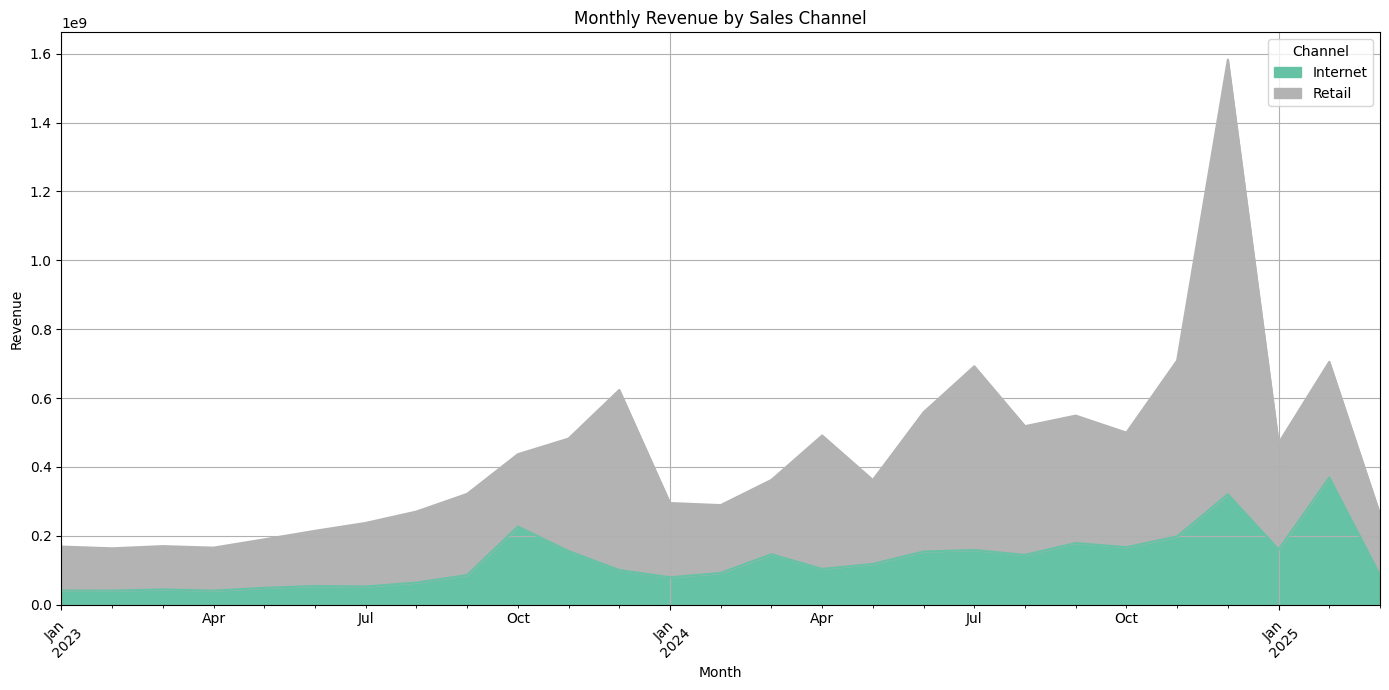

In [17]:
# Group by Month and Channel
monthly_channel = transactions.groupby(['Month', 'Channel'])['Revenue'].sum().reset_index()

# Pivot
pivoted_channel = monthly_channel.pivot(index='Month', columns='Channel', values='Revenue').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
pivoted_channel.plot.area(stacked=True, figsize=(14, 7), cmap='Set2')
plt.title('Monthly Revenue by Sales Channel')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()